# Cats vs Dogs — классификация изображений (Kaggle)

**Цель:** обучить модель бинарной классификации (кот/собака) и получить **Log Loss < 0.3** на Leaderboard.

Ноутбук включает:
- Подготовку данных из файлов `cat.*.jpg` и `dog.*.jpg` (структура соревнования);
- Визуализацию примеров;
- Модель на базе `VGG16` (ImageNet) с дообучением верхних слоёв;
- Аугментации, регуляризацию, `EarlyStopping`, `ReduceLROnPlateau`, `ModelCheckpoint`;
- Предсказания на тесте, TTA (test-time augmentation), формирование `submission.csv`.

In [ ]:
from google.colab import files
files.upload()  # загрузи kaggle.json

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip dogs-vs-cats-redux-kernels-edition.zip -d data/

In [ ]:
!unzip data/test.zip -d data/test
!unzip data/train.zip -d data/train

## 1. Импорты и окружение

In [5]:
import os, re, math, random, json, gc, glob, itertools
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers as L, regularizers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model

print('TensorFlow:', tf.__version__)
print('Eager:', tf.executing_eagerly())
print('GPU доступен:', tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
Eager: True
GPU доступен: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Параметры и пути
Скачайте данные соревнования в папку `./data/` либо укажите собственные пути.

In [6]:
# БАЗОВЫЕ НАСТРОЙКИ
DATA_DIR = Path('./data')  # корневая папка с данными
TRAIN_DIR = DATA_DIR / 'train'  # файлы вида cat.0.jpg, dog.0.jpg
TEST_DIR  = DATA_DIR / 'test'   # файлы вида 1.jpg, 2.jpg, ...

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS_STAGE1 = 5   # быстрый прогрев головы
EPOCHS_STAGE2 = 15  # дообучение верхних блоков
VAL_SPLIT = 0.1
AUTOTUNE = tf.data.AUTOTUNE
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

assert TRAIN_DIR.exists(), f"Не найдена папка {TRAIN_DIR}"
assert TEST_DIR.exists(), f"Не найдена папка {TEST_DIR}"

train_files = sorted(glob(str(TRAIN_DIR / '*.jpg')))
test_files  = sorted(glob(str(TEST_DIR / '*.jpg')))
print('Файлов train:', len(train_files))
print('Файлов test :', len(test_files))

Файлов train: 25000
Файлов test : 12500


## 3. Разметка и генераторы данных на `tf.data`

In [7]:
# Получаем метки: 1 = dog, 0 = cat
def label_from_path(p):
    name = os.path.basename(p)
    return 1 if name.startswith('dog') else 0

labels = np.array([label_from_path(p) for p in train_files], dtype=np.int32)

# Разделение на train/val
idx = np.arange(len(train_files))
np.random.shuffle(idx)
val_size = int(len(idx) * VAL_SPLIT)
val_idx = idx[:val_size]
trn_idx = idx[val_size:]

trn_files = [train_files[i] for i in trn_idx]
val_files = [train_files[i] for i in val_idx]
trn_labels = labels[trn_idx]
val_labels = labels[val_idx]

print('Train:', len(trn_files), 'Val:', len(val_files))

def read_image_tf(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)  # для VGG16
    return image

def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.random_saturation(image, 0.9, 1.1)
    return image

def make_ds(files, labels=None, training=False, batch_size=BATCH_SIZE):
    if labels is None:
        ds = tf.data.Dataset.from_tensor_slices((files,))
        ds = ds.map(lambda p: read_image_tf(p), num_parallel_calls=AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((files, labels))
        ds = ds.map(lambda p, y: (read_image_tf(p), tf.cast(y, tf.float32)), num_parallel_calls=AUTOTUNE)
        if training:
            ds = ds.map(lambda x, y: (augment(x), y), num_parallel_calls=AUTOTUNE)
            ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(trn_files, trn_labels, training=True)
val_ds   = make_ds(val_files, val_labels, training=False)

Train: 22500 Val: 2500


## 4. Визуализация нескольких примеров

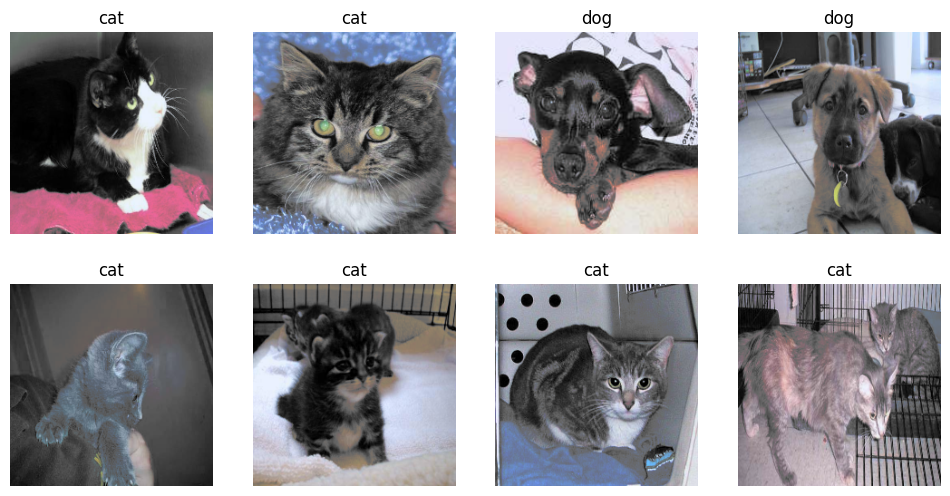

In [8]:
plt.figure(figsize=(12, 6))
for i, (images, targets) in enumerate(train_ds.take(1)):
    for j in range(min(8, images.shape[0])):
        ax = plt.subplot(2, 4, j+1)
        show = images[j].numpy()
        show = show[:, :, ::-1]  # VGG16 preprocess сдвигов не делает, но для наглядности переведём из BGR-подобного вида
        plt.imshow((show - show.min())/(show.max()-show.min()+1e-8))
        lbl = int(targets[j].numpy())
        plt.title('dog' if lbl==1 else 'cat')
        plt.axis('off')
plt.show()

## 5. Модель: VGG16 + новая «голова» и дообучение

In [9]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base.layers:
    layer.trainable = False

x = base.output
x = L.GlobalAveragePooling2D()(x)
x = L.Dropout(0.3)(x)
x = L.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = L.Dropout(0.3)(x)
out = L.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=out, name='dogs_vs_cats_vgg16')
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "dogs_vs_cats_vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 5.1 Обучение — этап 1 (замороженная база)

In [10]:
ckpt_path = 'vgg16_stage1.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
]
history1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_STAGE1, callbacks=callbacks)
model.load_weights(ckpt_path)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9230 - loss: 0.3470
Epoch 1: val_loss improved from inf to 0.08266, saving model to vgg16_stage1.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 161s 199ms/step - accuracy: 0.9230 - loss: 0.3468 - val_accuracy: 0.9832 - val_loss: 0.0827 - learning_rate: 0.0010
Epoch 2/5
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9672 - loss: 0.1242
Epoch 2: val_loss improved from 0.08266 to 0.07262, saving model to vgg16_stage1.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 137s 184ms/step - accuracy: 0.9672 - loss: 0.1241 - val_accuracy: 0.9852 - val_loss: 0.0726 - learning_rate: 0.0010
Epoch 3/5
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9719 - loss: 0.1080
Epoch 3: val_loss improved from 0.07262 to 0.07091, saving model to vgg16_stage1.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 148s 200ms/step - accuracy: 0.9719 - loss: 0.1080 - val_accuracy: 0.9852 - val_loss: 0.0709 - learning_rate: 0.0010
Epoch 4/5
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms

### 5.2 Разморозка верхних блоков и обучение — этап 2

In [11]:
# Разморозим верхние 4 блока VGG16 (последние 8–10 слоёв)
set_trainable = False
for layer in base.layers:
    if 'block5' in layer.name:
        set_trainable = True
    layer.trainable = set_trainable

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy', metrics=['accuracy'])

ckpt_path2 = 'vgg16_stage2.keras'
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(ckpt_path2, monitor='val_loss', save_best_only=True, verbose=1)
]
history2 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_STAGE2, callbacks=callbacks2)
model.load_weights(ckpt_path2)
model.save('cats-dogs-vgg16-finetuned.keras')

Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9647 - loss: 0.1230
Epoch 1: val_loss improved from inf to 0.06534, saving model to vgg16_stage2.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 175s 227ms/step - accuracy: 0.9648 - loss: 0.1229 - val_accuracy: 0.9828 - val_loss: 0.0653 - learning_rate: 1.0000e-04
Epoch 2/15
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9859 - loss: 0.0626
Epoch 2: val_loss improved from 0.06534 to 0.05248, saving model to vgg16_stage2.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 163s 220ms/step - accuracy: 0.9859 - loss: 0.0626 - val_accuracy: 0.9876 - val_loss: 0.0525 - learning_rate: 1.0000e-04
Epoch 3/15
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9909 - loss: 0.0443
Epoch 3: val_loss did not improve from 0.05248
704/704 ━━━━━━━━━━━━━━━━━━━━ 209s 231ms/step - accuracy: 0.9909 - loss: 0.0443 - val_accuracy: 0.9836 - val_loss: 0.0722 - learning_rate: 1.0000e-04
Epoch 4/15
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9937

## 6. Предсказания на тесте + TTA и сабмишн

In [12]:
def make_test_ds(files, batch_size=BATCH_SIZE, tta=False):
    ds = tf.data.Dataset.from_tensor_slices(files)
    ds = ds.map(lambda p: read_image_tf(p), num_parallel_calls=AUTOTUNE)
    if tta:
        # простая TTA: оригинал + горизонтальный флип
        def add_tta(img):
            img_flipped = tf.image.flip_left_right(img)
            return tf.stack([img, img_flipped], axis=0)  # [2, H, W, C]
        ds = ds.map(lambda x: add_tta(x), num_parallel_calls=AUTOTUNE)
        ds = ds.unbatch()
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

test_ds = make_test_ds(test_files, tta=True)
preds = model.predict(test_ds, verbose=1).reshape(-1)

# Если была TTA (2x), усредним пары
if len(preds) == 2 * len(test_files):
    preds = preds.reshape(-1, 2).mean(axis=1)

# Соберём submission.csv
ids = [int(re.search(r'(\d+)\.jpg$', os.path.basename(p)).group(1)) for p in test_files]
submission = pd.DataFrame({'id': ids, 'label': preds})
submission = submission.sort_values('id')
submission.to_csv('submission.csv', index=False)
submission.head()

782/782 ━━━━━━━━━━━━━━━━━━━━ 136s 172ms/step


,id,label
0,1,1.000000e+00
3612,2,1.000000e+00
4723,3,1.000000e+00
5834,4,1.000000e+00
6945,5,1.298178e-08


## 7. Оценка и логгирование метрик (локально на валидации)
В соревновании оценивается **Log Loss**. Ниже — пример вычисления на валидационном наборе (для контроля качества перед отправкой).

In [14]:
from sklearn.metrics import log_loss, accuracy_score

val_pred = model.predict(val_ds).reshape(-1)
val_true = np.array(list(itertools.chain.from_iterable([y.numpy().tolist() for _, y in val_ds])))
ll = log_loss(val_true, val_pred)
acc = accuracy_score(val_true, (val_pred>0.5).astype(int))
print({'val_logloss': ll, 'val_acc': acc})

79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step
{'val_logloss': 0.03234690295142616, 'val_acc': 0.9876}
